In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Transformation / PreProcessing Work

In [2]:
# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('../{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

# Normalize data frame.
normalized_df = (feature_df - feature_df.mean()) / feature_df.std()

In [3]:
# Perform a train-test split. Looking at the above data, let's train on all data prior to end of year 2005.
# Test on all data from 2005 to end of year 2019
# Keep beginning of 2020 through 2021 seperate for analysis and comparisons with other methods.
dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = feature_df.iloc[:training_ends, :], feature_df.iloc[training_ends:test_ends, :], feature_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = response_df.iloc[:training_ends, :], response_df.iloc[training_ends:test_ends, :], response_df.iloc[test_ends:, :]
X_train.shape, X_test.shape, X_analysis.shape

((216, 58), (120, 58), (19, 58))

In [4]:
##################
# UNIVARIATE CNN #
##################
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [5]:
X_train, y_train = split_sequence(y_train.values[:, 0], 12)
X_test, y_test = split_sequence(y_test.values[:, 0], 12)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((204, 12), (204,), (108, 12), (108,))

In [6]:
# Reshape from (samples, timesteps) to (samples, timesteps, features)
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], 1, n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], 1, n_features))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((204, 12, 1), (204, 1, 1), (108, 12, 1), (108, 1, 1))

In [7]:
# CNN Model
cnn_simple = tf.keras.models.Sequential(name="Simple CNN")
cnn_simple.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_simple.add(tf.keras.layers.Dropout(0.3))
cnn_simple.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_simple.add(tf.keras.layers.Flatten())
cnn_simple.add(tf.keras.layers.Dense(32, activation='relu'))
cnn_simple.add(tf.keras.layers.Dropout(0.2))
cnn_simple.add(tf.keras.layers.Dense(1))
cnn_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse', metrics='accuracy')
cnn_simple.summary()

Model: "Simple CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 64)            192       
_________________________________________________________________
dropout (Dropout)            (None, 11, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                10272     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

2021-09-06 14:42:23.148498: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2021-09-06 14:42:23.333774: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 19.4156 - accuracy: 0.0000e+00 - val_loss: 7.0370 - val_accuracy: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 17.8455 - accuracy: 0.0000e+00 - val_loss: 6.9541 - val_accuracy: 0.0000e+00
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 16.8363 - accuracy: 0.0000e+00 - val_loss: 7.2076 - val_accuracy: 0.0000e+00
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 15.4604 - accuracy: 0.0000e+00 - val_loss: 8.6538 - val_accuracy: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 15.4802 - accuracy: 0.0000e+00 - val_loss: 8.0279 - val_accuracy: 0.0000e+00
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 16.0889 - accuracy: 0.0000e+00 - val_loss: 8.4725 - val_accuracy: 0.0000e+00
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 14.6821 - accuracy: 0.0000e+00 - v

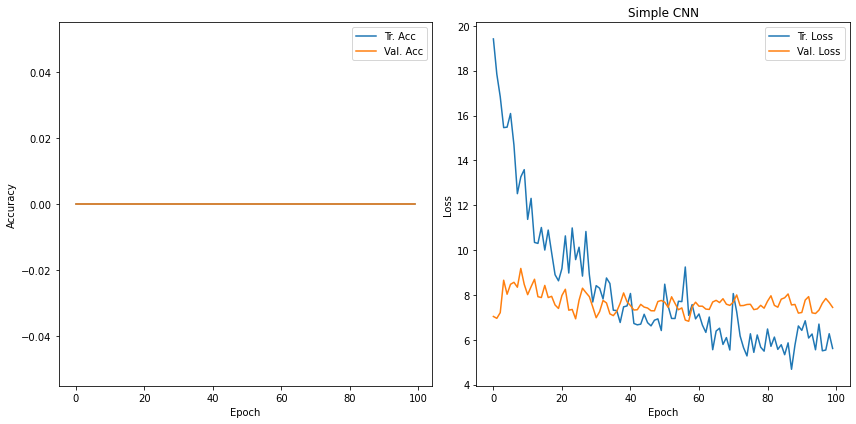

In [8]:
history = cnn_simple.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=False)
graphHistory(history, 'Simple CNN')